In [5]:
import os
import sys

git_dir = r"C:/Users/Aditya/Github/WorldBank/iQual"
sys.path.append(git_dir)
sys.path.append(os.path.join(git_dir,'src'))

### Imports

In [6]:
import os
import random
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

from iqual import nlpmodel, preprocessing, evaluation, crossval, tests

### Load datasets

In [7]:
data_dir    = os.path.join(git_dir,"data")

### Enhanced qualitative data
enhanced_df = pd.read_csv(os.path.join(data_dir,"enhanced_bootstrap_mean.csv"))

### Quantitative data
quant_df    = pd.read_csv(os.path.join(data_dir,"quant_data.csv"))

In [ ]:
### Keep 

In [8]:
annotated_df = enhanced_df.loc[enhanced_df.annotated==1].drop(columns=['annotated'])

### Merge Data

In [9]:
data         = pd.merge(annotated_df,quant_df,on=['uid','data_round'],how='left')

> ### Select variables of interest

In [10]:
categorical_vars = [
                    'refugee',       # Refugee
                    'hh_head_sex',   # Female HH Head
                    'eld_sex',       # Female eldest child
                    'parent_reledu', # Religiously educated parent
                    'data_round',    # R3
]

continuous_vars = [
     'num_child', # Number of Children
     'hh_head_age', # Age of HH Head
     'parent_eduyears', # Parent's years of education
     'eld_age',       # Age of eldest child
     'hh_asset_index', # HH asset index
     'hh_income',      # HH Income
     'int_trauma_exp', # Trauma Experience
]

annotation_vars = [
     "ability_high",
     "ability_low",
     "awareness_information_high",
     "awareness_information_low",
     "budget_high",
     "budget_low",
     "covid_impacts",
     "education_high",
     "education_low",`
     "education_neutral",
     "education_religious",
     "entrepreneur",
     "job_secular",
     "marriage",
     "migration",
     "no_ambition",
     "public_assistance",
     "reliance_on_god",
     "religious",
     "secular",
     "vague_job",
     "vague_non_specific",
     "vocational_training",
     "worries_anxieties",
    ]

> ### Bias tests (For each bootstrap-run)

In [50]:
datasets = []
for b, boot_df in data.groupby('bootstrap_run'):
    bias = tests.Bias(boot_df,
                      annotation_vars=annotation_vars,
                      continuous_regressors=continuous_vars,
                      categorical_regressors=categorical_vars,
                     )
    bias.fit_all()
    datasets.extend([{
        'bootstrap_run':b,
        'annotation':annotation,
        'fstat_enh':result.fvalue,
        'log_fstat_enh':np.log(result.fvalue),
        'pval_enh':result.f_pvalue,
    }   for annotation, result in bias.model_fits.items()])
    
bias_df = pd.DataFrame(datasets)    
bias_df = bias_df.sort_values('annotation')

> ### Significance 

In [51]:
bias_df['sig_level'] = '>5%'
bias_df.loc[bias_df.pval_enh <= 0.01, 'sig_level'] = '<1%'
bias_df.loc[(bias_df.pval_enh > 0.01) & (bias_df.pval_enh <= 0.05), 'sig_level'] = '<5%'

> ### Bias test (Average across Bootstrap runs)

In [52]:
grouped_df = data.drop(columns=['bootstrap_run']).groupby(['uid','data_round','refugee_status'])
avg_data   = grouped_df.mean(numeric_only=False).reset_index()

bias = tests.Bias(avg_data,
                  annotation_vars=annotation_vars,
                  continuous_regressors=continuous_vars,
                  categorical_regressors=categorical_vars,
                 )
bias.fit_all()

bias_avg_df = pd.DataFrame([{
        'annotation':annotation,
        'fstat_enh':result.fvalue,
        'log_fstat_enh':np.log(result.fvalue),
        'pval_enh':result.f_pvalue,
    }   for annotation, result in bias.model_fits.items()])

bias_avg_df = bias_avg_df.sort_values('annotation',ascending=True,ignore_index=True)

> ### Significance 

In [53]:
bias_avg_df['sig_level'] = '>5%'
bias_avg_df.loc[bias_avg_df.pval_enh <= 0.01, 'sig_level'] = '<1%'
bias_avg_df.loc[(bias_avg_df.pval_enh > 0.01) & (bias_avg_df.pval_enh <= 0.05), 'sig_level'] = '<5%'

## Visualize results

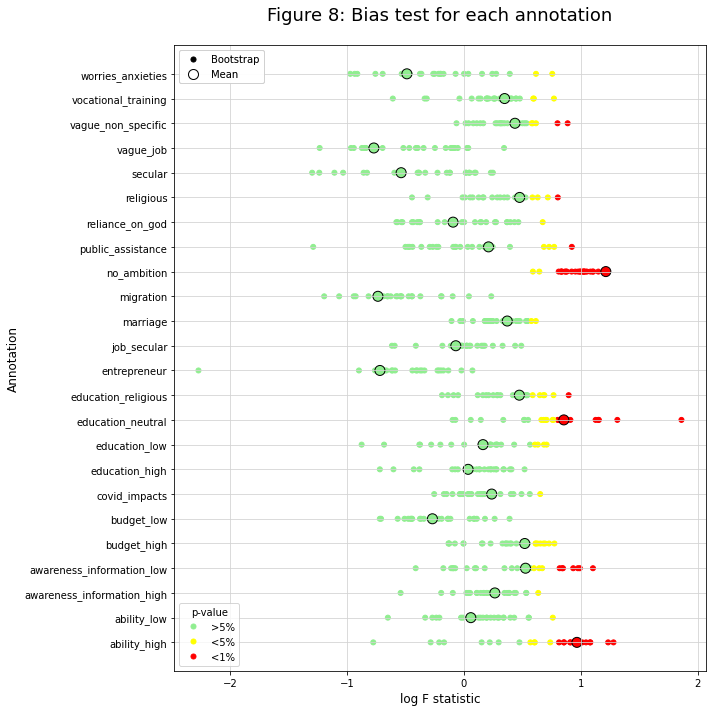

In [54]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

#### Colors for p-value
pvalue_color_dict = {'>5%':'lightgreen','<5%':'yellow','<1%':'red'}

fig, ax = plt.subplots(figsize=(10,10))

#### Bias (Bootstrap)
ax.scatter(bias_df['log_fstat_enh'], bias_df['annotation'], 
           s=25, 
           c=bias_df['sig_level'].replace(pvalue_color_dict),
           edgecolors=bias_df['sig_level'].replace(pvalue_color_dict),
          )

#### Bias (Average)
ax.scatter(bias_avg_df['log_fstat_enh'], bias_avg_df['annotation'], 
           s=100, 
           c=bias_avg_df['sig_level'].replace(pvalue_color_dict),
           edgecolors='k',           
          )


# Legend

# 1. Legend for p-value
pval_patches    = [
    Line2D([0], [0], 
           marker='.', c=color, lw=0,ms=10,
           label=significance,
          )
     for significance, color in pvalue_color_dict.items() ]

first_legend = plt.legend(handles=pval_patches,title='p-value',loc='lower left')
plt.gca().add_artist(first_legend)

# 2. Legend for Mean/Bootsrap
marker_patches =  [
    Line2D([0], [0], marker='.', c='k', lw=0, ms=10, label="Bootstrap"),
    Line2D([0], [0], marker='o', c='k', lw=0,  ms=10, mfc='w', label="Mean")
]

second_legend = plt.legend(handles=marker_patches, loc='upper left')
plt.gca().add_artist(second_legend)

# Axes
ax.grid(True,color='lightgray',)
ax.set_xlabel('log F statistic',fontsize=12)
ax.set_ylabel('Annotation', fontsize=12)
ax.set_title('Figure 8: Bias test for each annotation',fontsize=18, pad=25)

plt.tight_layout()
plt.show()